# Pharyngeal endoderm development analysis with the RealTimeKernel

## Import packages

In [1]:
import sys

import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "pharyngeal_endoderm" / "results").mkdir(parents=True, exist_ok=True)

In [6]:
N_JOBS = 8

## Constants

## Data loading

In [7]:
adata = sc.read(DATA_DIR / "pharyngeal_endoderm" / "processed" / "adata_velo.h5ad")

adata.obs["cluster_fine"] = (
    pd.read_csv(DATA_DIR / "pharyngeal_endoderm" / "raw" / "cluster_data.csv", index_col=0)
    .loc[adata.obs_names, "res.1"]
    .values
)
adata.obs["cluster_fine"] = adata.obs["cluster_fine"].astype(str).astype("category")

adata = adata[adata.obs["cluster_fine"].isin(["2", "4", "9", "12", "25", "26"]), :].copy()
adata.uns["cluster_name_colors"] = ["#023fa5", "#bec1d4", "#b5bbe3", "#e07b91", "#11c638"]

adata.obs["cluster_name"] = (
    adata.obs["cluster_name"]
    .astype(str)
    .astype("category")
    .cat.rename_categories({"nan": "progenitors"})
    .cat.reorder_categories(["progenitors"] + adata.obs["cluster_name"].cat.categories.tolist())
)
adata.uns["cluster_name_colors"] = ["#dedede"] + ["#023fa5", "#bec1d4", "#b5bbe3", "#e07b91", "#11c638"]

adata.obsm["X_umap"] = (
    pd.read_csv(DATA_DIR / "pharyngeal_endoderm" / "processed" / "umap_subsetted_data.csv", index_col=0)
    .loc[adata.obs_names, :]
    .values
)

adata

AnnData object with n_obs × n_vars = 11073 × 27998
    obs: 'cluster_name', 'day', 'is_doublet', 'cluster_fine'
    uns: 'cluster_name_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Data preprocessing

In [8]:
scv.pp.filter_and_normalize(adata, min_counts=20, n_top_genes=2000)

Filtered out 13377 genes that are detected 20 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/vol/storage/philipp/code/scvelo_dev/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:02:33)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


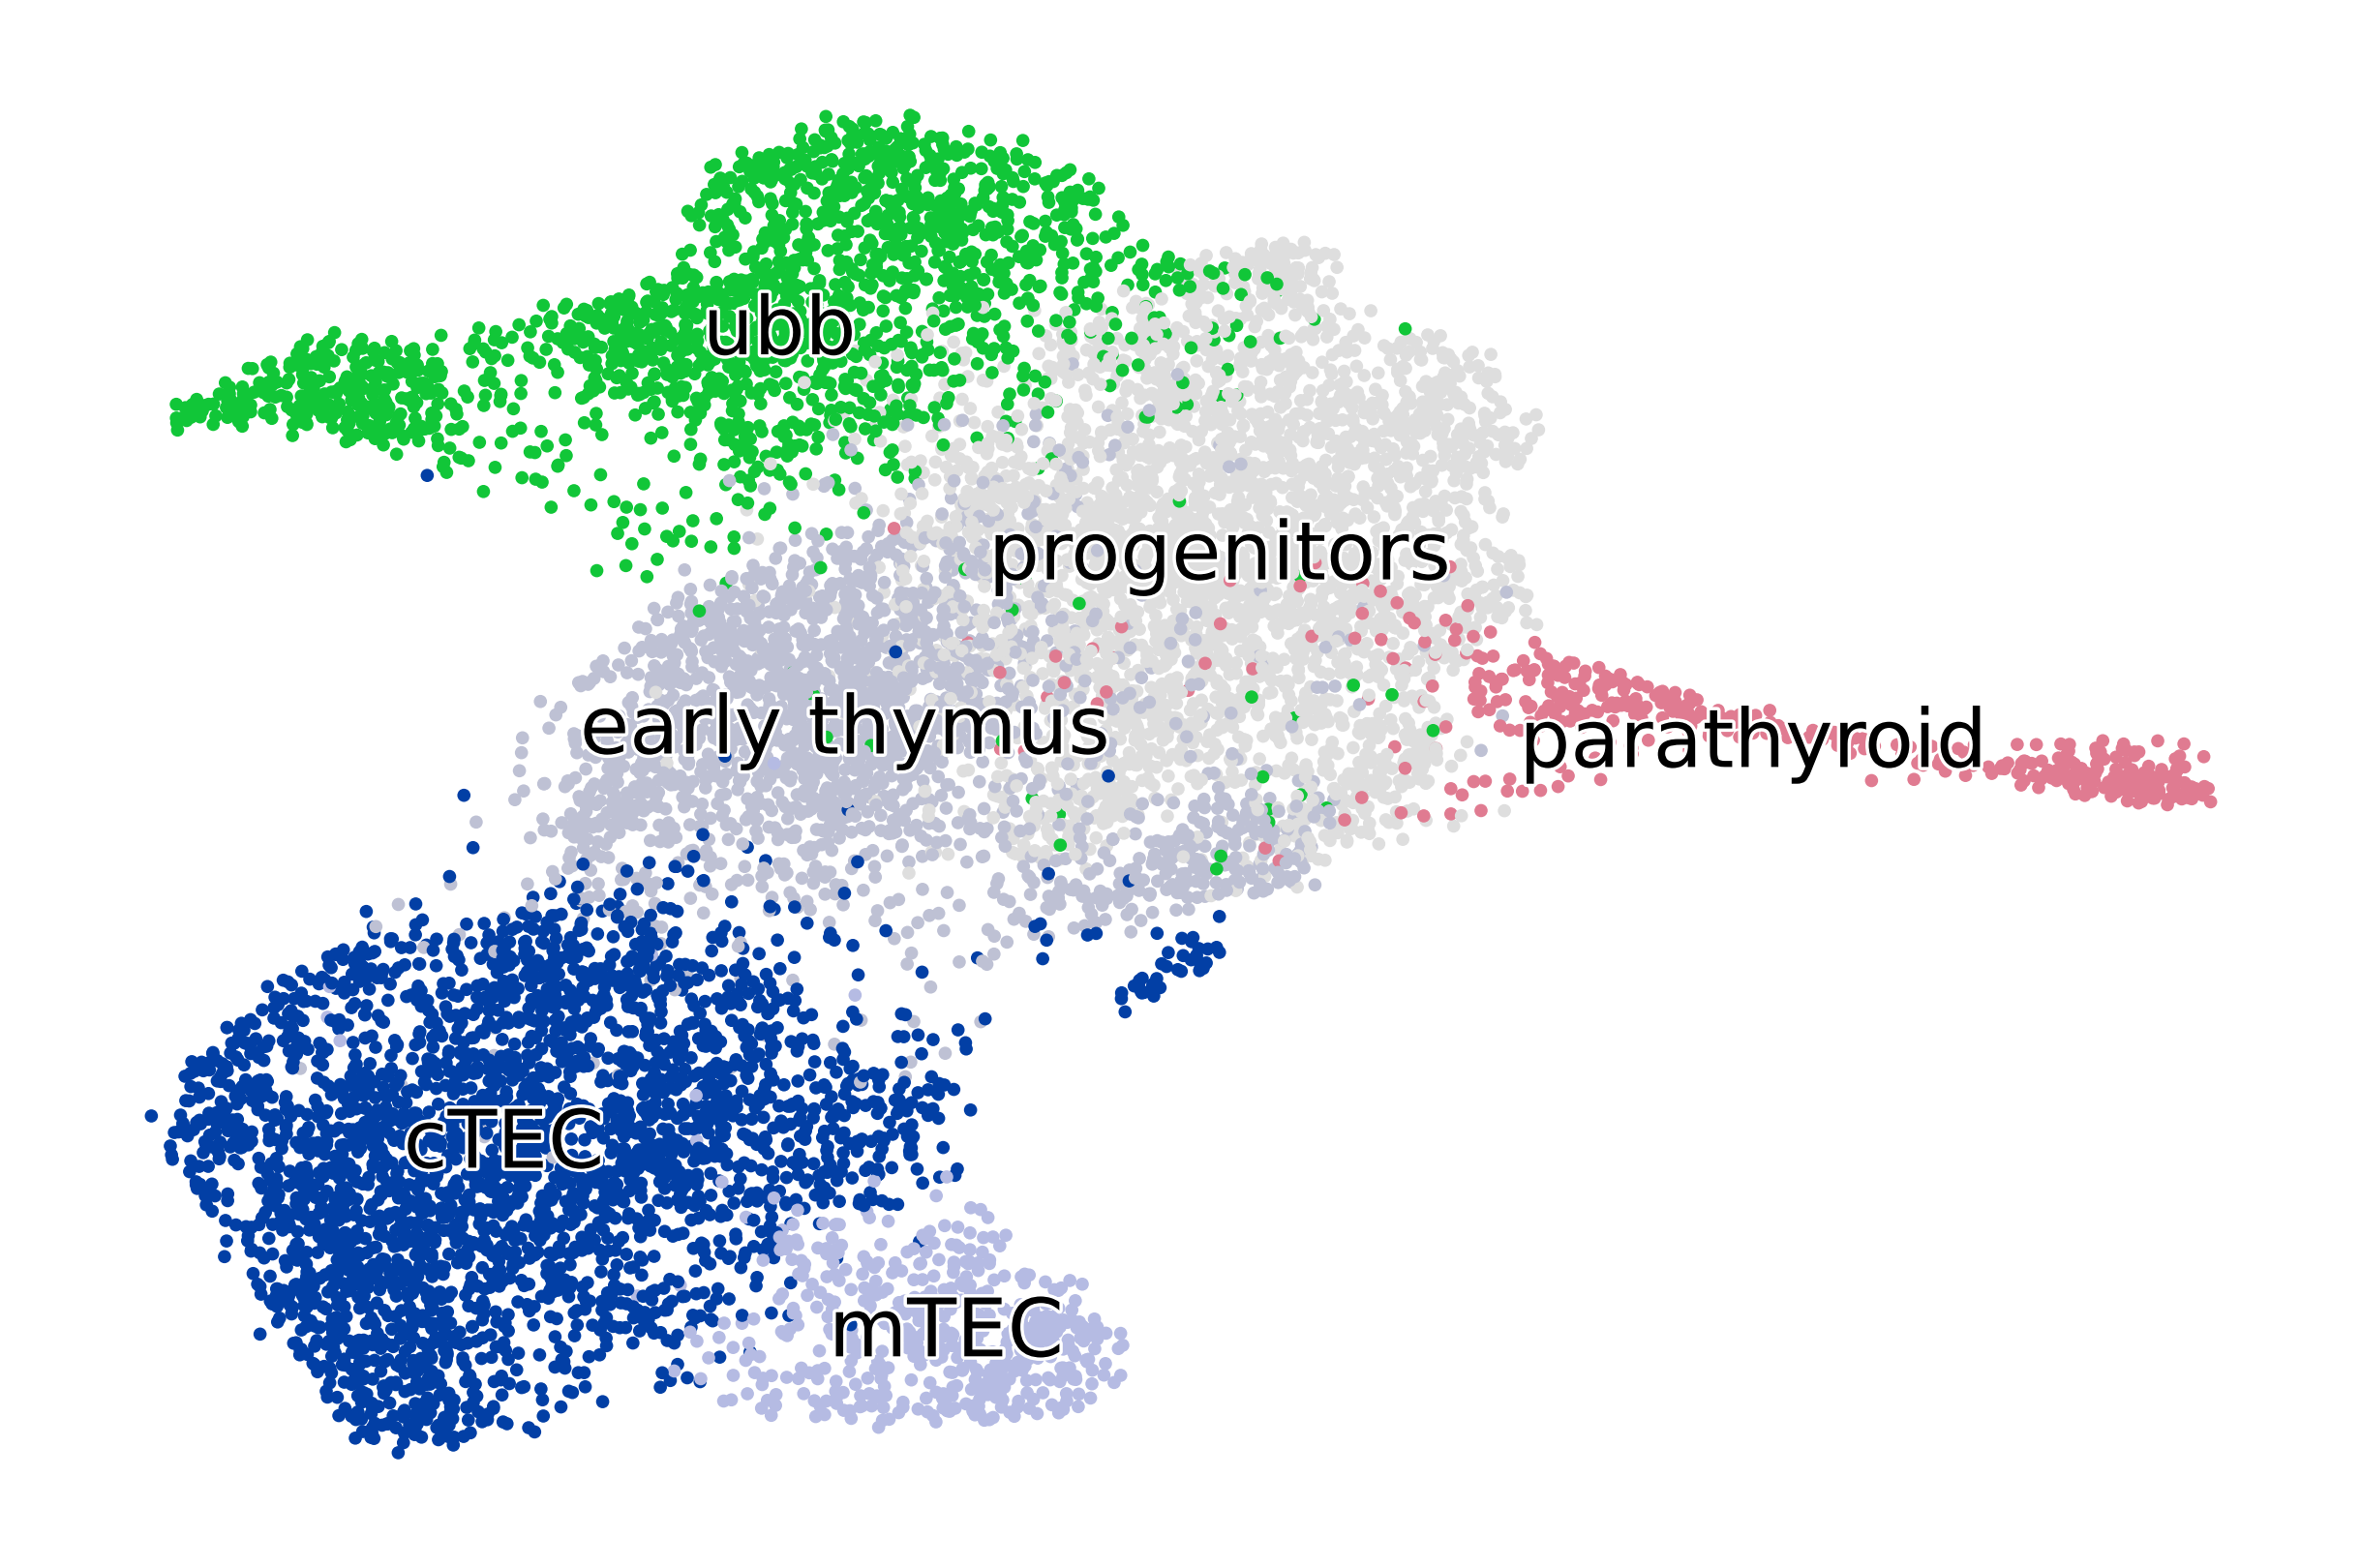

In [10]:
if running_in_notebook():
    scv.pl.scatter(
        adata, basis="umap", c="cluster_name", title="", dpi=250, legend_fontsize=12, legend_fontweight="normal"
    )

## RNA velocity inference

In [11]:
if (DATA_DIR / "pharyngeal_endoderm" / "results" / "adata_velo_fit-subsetted_data.h5ad").is_file():
    adata = sc.read(DATA_DIR / "pharyngeal_endoderm" / "results" / "adata_velo_fit-subsetted_data.h5ad")
else:
    scv.tl.recover_dynamics(adata, n_jobs=N_JOBS)
    scv.tl.velocity(adata, mode="dynamical")
    adata.write(DATA_DIR / "pharyngeal_endoderm" / "results" / "adata_velo_fit-subsetted_data.h5ad", compression="gzip")

## CellRank analysis

### Kernel

In [12]:
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/11073 [00:00<?, ?cell/s]

Using `softmax_scale=2.9151`


  0%|          | 0/11073 [00:00<?, ?cell/s]

    Finish (0:00:28)
Computing transition matrix based on `adata.obsp['connectivities']`
DEBUG: Density normalizing the transition matrix
    Finish (0:00:00)


## Estimator

In [13]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[8]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


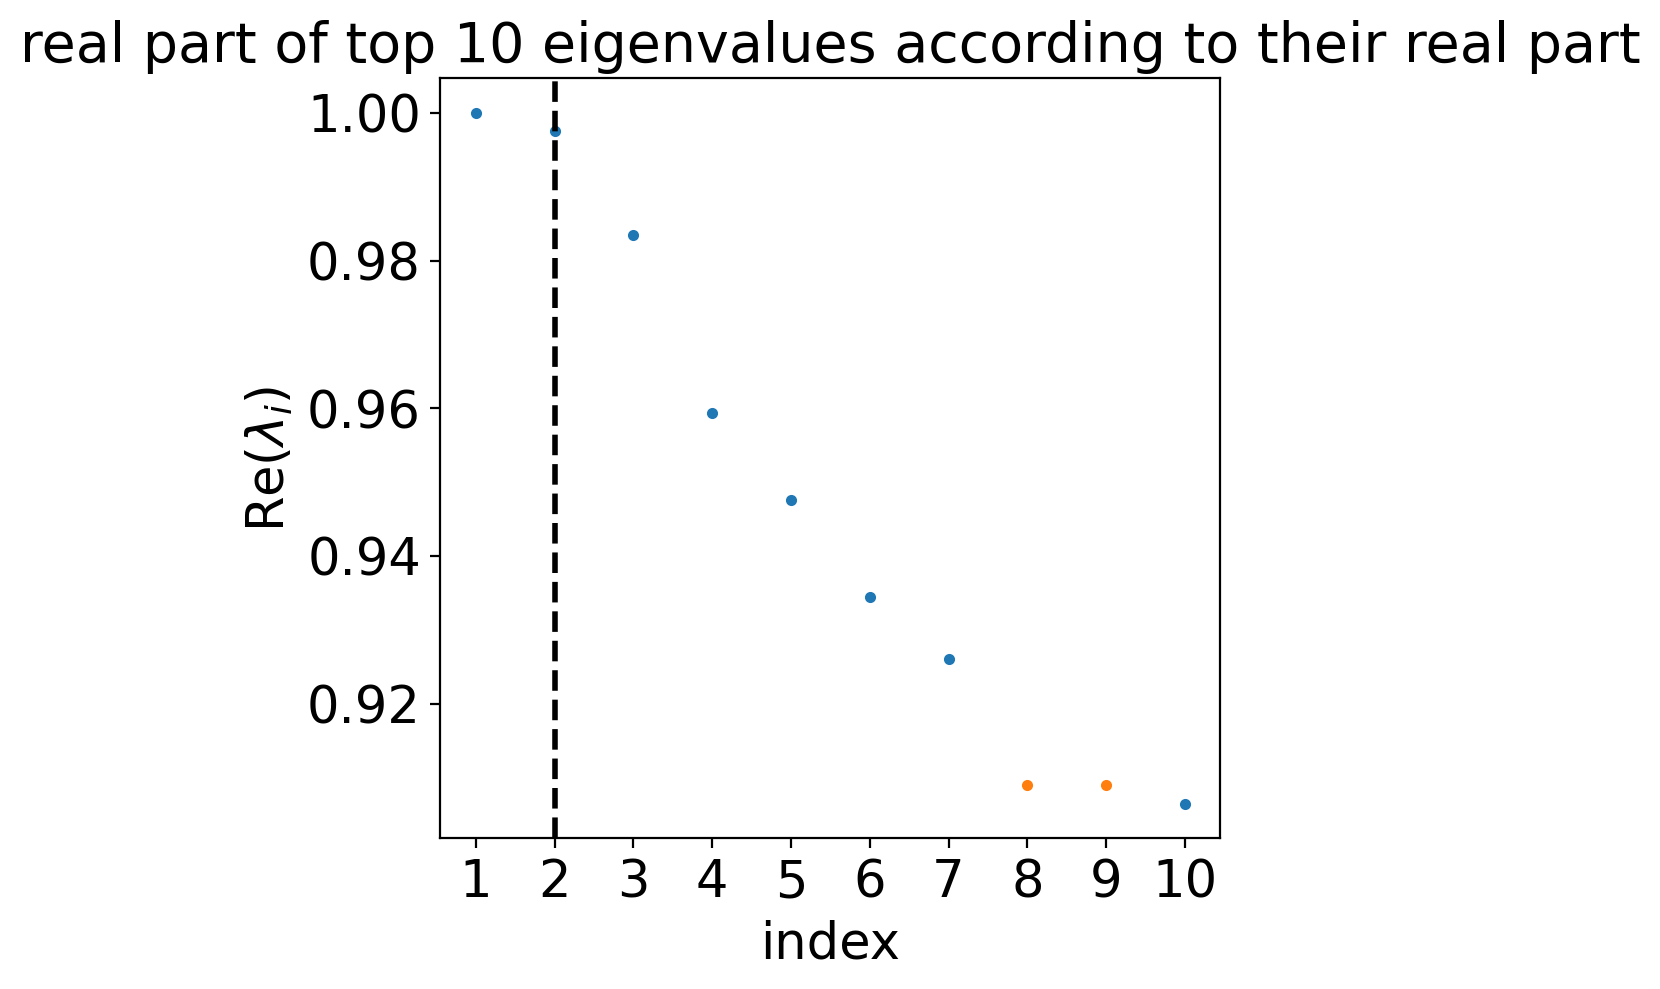

In [14]:
estimator.compute_schur(n_components=10)
estimator.plot_spectrum(real_only=True)

In [15]:
terminal_states = ["parathyroid", "ubb", "cTEC", "mTEC"]
cluster_key = "cluster_name"

if (DATA_DIR / "pharyngeal_endoderm" / "results" / "tsi-subsetted_data-vk.csv").is_file():
    tsi_df = pd.read_csv(DATA_DIR / "pharyngeal_endoderm" / "results" / "tsi-subsetted_data-vk.csv")
    estimator._tsi = AnnData(tsi_df, uns={"terminal_states": terminal_states, "cluster_key": cluster_key})
    tsi_score = estimator.tsi(n_macrostates=10, terminal_states=terminal_states, cluster_key=cluster_key)
else:
    tsi_score = estimator.tsi(n_macrostates=10, terminal_states=terminal_states, cluster_key=cluster_key)
    estimator._tsi.to_df().to_csv(
        DATA_DIR / "pharyngeal_endoderm" / "results" / "tsi-subsetted_data-vk.csv", index=False
    )

print(f"TSI score: {tsi_score:.2f}")

TSI score: 0.91


/vol/storage/miniconda3/envs/cr2-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


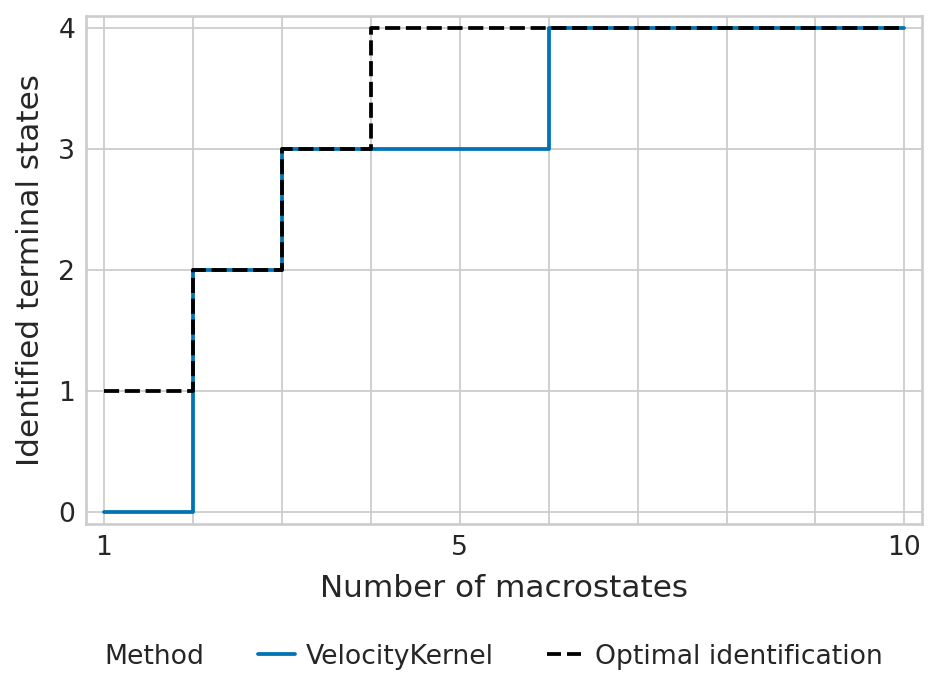

In [16]:
# For nice name in figure legend
estimator.kernel.__class__.__name__ = "VelocityKernel"
palette = {"VelocityKernel": "#0173b2", "Optimal identification": "#000000"}

if SAVE_FIGURES:
    fpath = FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm" / f"tsi-subsetted_data-vk.{FIGURE_FORMAT}"
else:
    fpath = None

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    estimator.plot_tsi(palette=palette, save=fpath)
    plt.show()